# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Project 4: Predict Dengue Cases

# Modelling

## Importing packages for ARIMA model

In [1]:
#import general libraries
import pandas as pd
import numpy as np
import copy
import re
import matplotlib.pyplot as plt
import seaborn as sns

#import libraries for modelling
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm # to do Auto ARIMA
from pmdarima.arima import ADFTest,KPSSTest # to perform ADF test 
from statsmodels.tsa.stattools import adfuller, kpss # alternate ADF test
from sklearn.model_selection import train_test_split # for splitting the train and test set from the data
from sklearn.metrics import mean_absolute_percentage_error # metric that's used to evaluate the performance of a time series model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #for plotting the acf and pacf graphs

In [2]:
wid_2012_2023 = pd.read_csv('../data/weekly_infectious_disease_bulletin_year_2012_2023.csv')

In [3]:
wid_2012_2023['end'] = pd.to_datetime(wid_2012_2023['end'])

In [5]:
ss = MinMaxScaler()

In [6]:
wid_2012_2023_ades_vector = copy.deepcopy(wid_2012_2023[['dengue fever','dengue haemorrhagic fever','chikungunya fever','zika virus infection']][0:605])

wid_2012_2023_ades_vector[['dengue fever scaled','dengue haemorrhagic fever scaled','chikungunya fever scaled','zika virus infection scaled']] = ss.fit_transform(wid_2012_2023_ades_vector[['dengue fever','dengue haemorrhagic fever','chikungunya fever','zika virus infection']])
wid_2012_2023_ades_vector = pd.DataFrame(wid_2012_2023_ades_vector)
wid_2012_2023_ades_vector.index = wid_2012_2023['end'][0:605]

In [7]:
wid_2012_2023_ades_vector.fillna(0, inplace = True)

## train-test-split

As per mentioned in our problem statement, we will try to predict the number of dengue cases 4 months ahead. Therefore, we will set the y_test to 4*4 weeks = roughly 4 months.

In [8]:
y = wid_2012_2023_ades_vector['dengue fever']
y_train = y[:len(y)-(4*4)]
y_test = y[len(y_train):]

In [9]:
wid_2012_2023_ades_vector['dengue fever']

end
2012-01-07     74.0
2012-01-14     64.0
2012-01-21     60.0
2012-01-28     50.0
2012-02-04     84.0
              ...  
2023-07-01    271.0
2023-07-08    235.0
2023-07-15    209.0
2023-07-22    202.0
2023-07-29    213.0
Name: dengue fever, Length: 604, dtype: float64

## ARIMA (baseline)

Why ARIMA?

What is ARIMA? AR I MA

    AR: Number of cases of dengue is influenced by the number of cases of dengue in the past.
    MA: Captures fluctuations induced by rainfall, changing habitats (random clearing of stagnant water) etc.
    I: Account for stationarity and mitigates the effect of trends

In [10]:
def plot_forecast(y_train, y_test, arima_model, X_test=None):
    # Generate len(y_test) number of predictions
    y_pred = arima_model.predict(n_periods = len(y_test), X=X_test) # we want as many future data point predictions as there are in y_test

    # Plot data.
    plt.figure(figsize=(16,9))

    # Plot training data. don't need to explicitly pass x-axis for chart, taken as the date index by matplotlib
    plt.plot(y_train, color='blue', label='y_train')

    # Plot testing data. don't need to explicitly pass x-axis for chart, taken as the date index by matplotlib
    plt.plot(y_test, color='orange', label='y_test', alpha = 0.7)

    # Plot predicted test values. as shared previously, there are no index in y_pred 
    # so, we need to explicitly pass the `x-axis` (dates) to compare for same timeframe as y_test and access y_pred vs actual y_test
    # we can use y_test.index to get the index of y_test as confirmed earlier in y_test.head()
    plt.plot(y_pred, color='green', label='y_pred', alpha = 0.9, ls = '--')
    
    # Find the MAPE (mean abs percentage error) of the predictions
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html
    mape = mean_absolute_percentage_error(y_test, y_pred) # like all sklearn metrics we've used, pass y_actual, y_pred

    plt.title(label = f'Dengue Cases \n MAPE: {mape}', fontsize=16) #\n is just for new line to print MAPE 1 line after header 'Sales Predictions', while .2f rounds MAPE to 2 decimals
    plt.legend(fontsize = 20, loc = 'upper left'); # for legend to be displayed in our plot

## Fitting ARIMA model

First, we determine the I value. This is done by checking stationarity of the dengue fever time series and it's ordered differences.

### Determining d

#### Checking for Stationarity of y_train

##### Visual Check

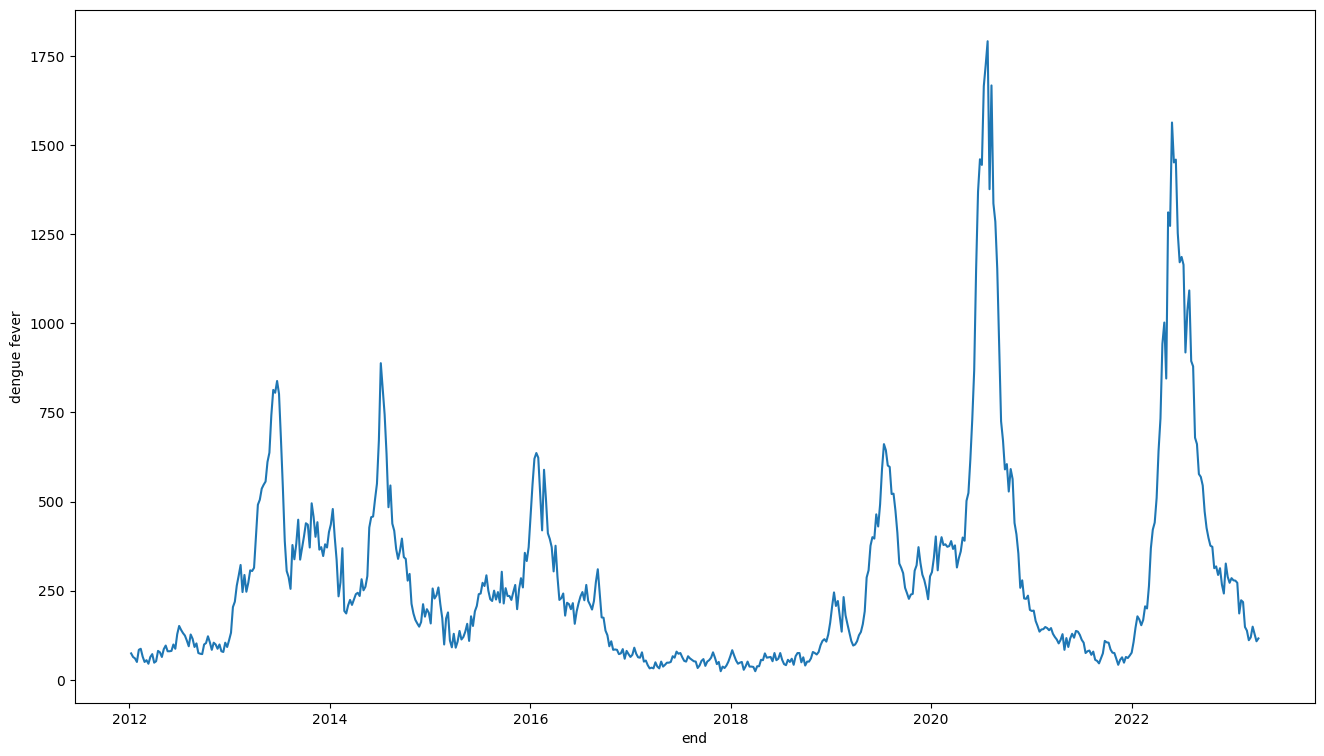

In [11]:
plt.figure(figsize=(16,9))
sns.lineplot(y_train);

Stationarity:

- Constant Mean
  - The mean does not apepar to be constant. For example, the mean between 2014 to 2016 will be different from that of 2017 to 2019.
- Since the Constant Mean criterion looks to be violated, we have reason to believe that the dengue fever cases time series is not stationary.

##### Metric Check

Choice of stationarity check: ADF vs KPSS

Null assumptions for ADF and KPSS:
- KPSS: assumes that the data is stationary
- ADF: assumes that that there is a unit root in the data

Our data does not look to be stationary. To confirm if we should difference the time series, we do both KPSS and ADF tests.

In [12]:
adf_test = ADFTest(alpha = 0.05) # instantiate ADF test with setting the threshold for p-value to accept/reject null hypothesis
# returns a tuple containing p-value for the ADF test and if we should try to difference the time series
adf_test.should_diff(y_train)

(0.01, False)

Since the p-value for the ADF test is 0.01 < 0.05, we have enough evidence to reject the null hypothesis of the existence of unit root in y_train and conclude that y_train is stationary.

Caveat: ADF test only tests for the existence of a single unit root. 

In [13]:
kpss_test = KPSSTest(alpha = 0.05)

kpss_test.should_diff(y_train)

(0.024765409791164927, True)

Since the p-value for the KPSS test is 0.01 < 0.05, we have enough evidence to reject the null hypothesis that y_train is stationary.

#### Checking for Stationarity of y_train.diff()

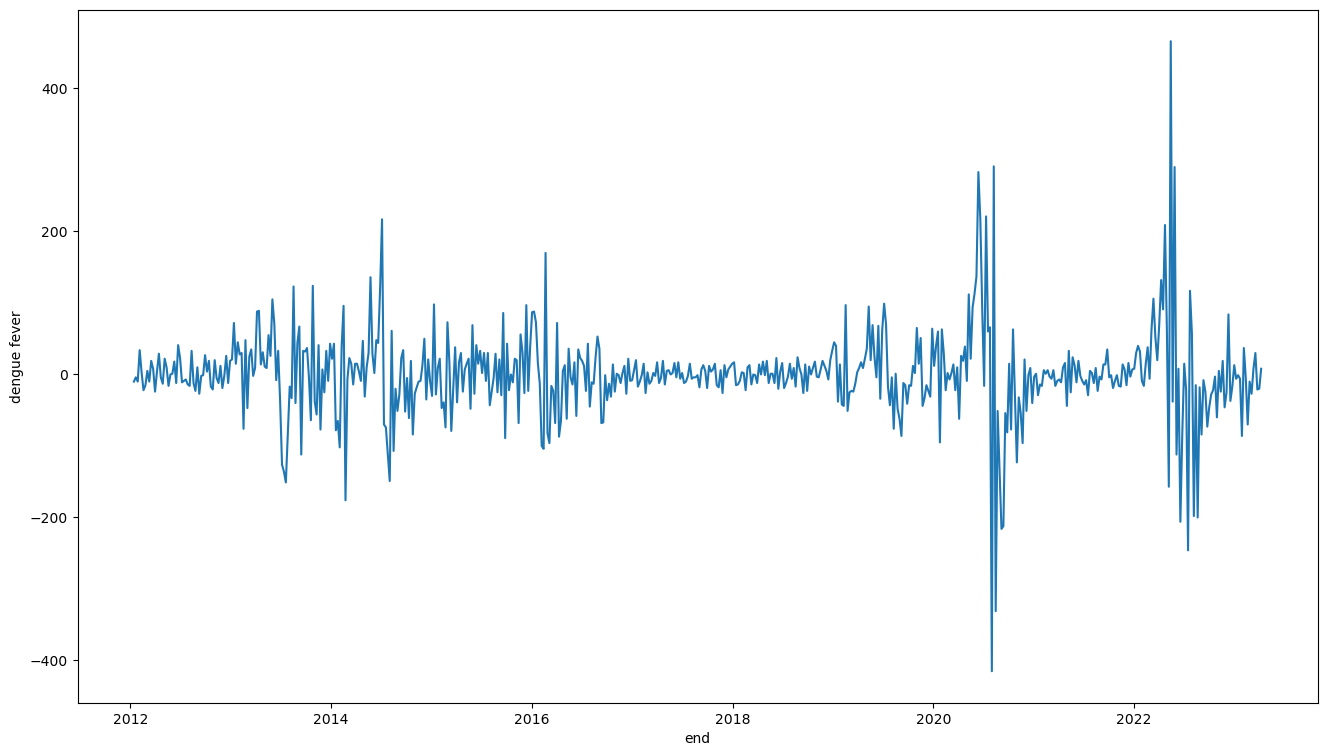

In [14]:
plt.figure(figsize = (16,9))
sns.lineplot(y_train.diff().dropna());

In [15]:
adf_test.should_diff(y_train.diff(1).dropna())

(0.01, False)

Since p-value = 0.01 < 0.05, we reject the null hypothesis that there is a unit root in the first order differenced time series.

In [16]:
kpss_test.should_diff(y_train.diff(1).dropna())

(0.1, False)

Since p-value = 0.1 > 0.05, we do not reject the null hypothesis that the first order differenced time seires is stationary.

Since both test agree that the first order differenced time series is stationary, we will set d to be 1 for our ARIMA model.

### Determining p and q

We will determine the range or q and p for the maximum order of MA and AR respectively by looking at the acf and the pacf.

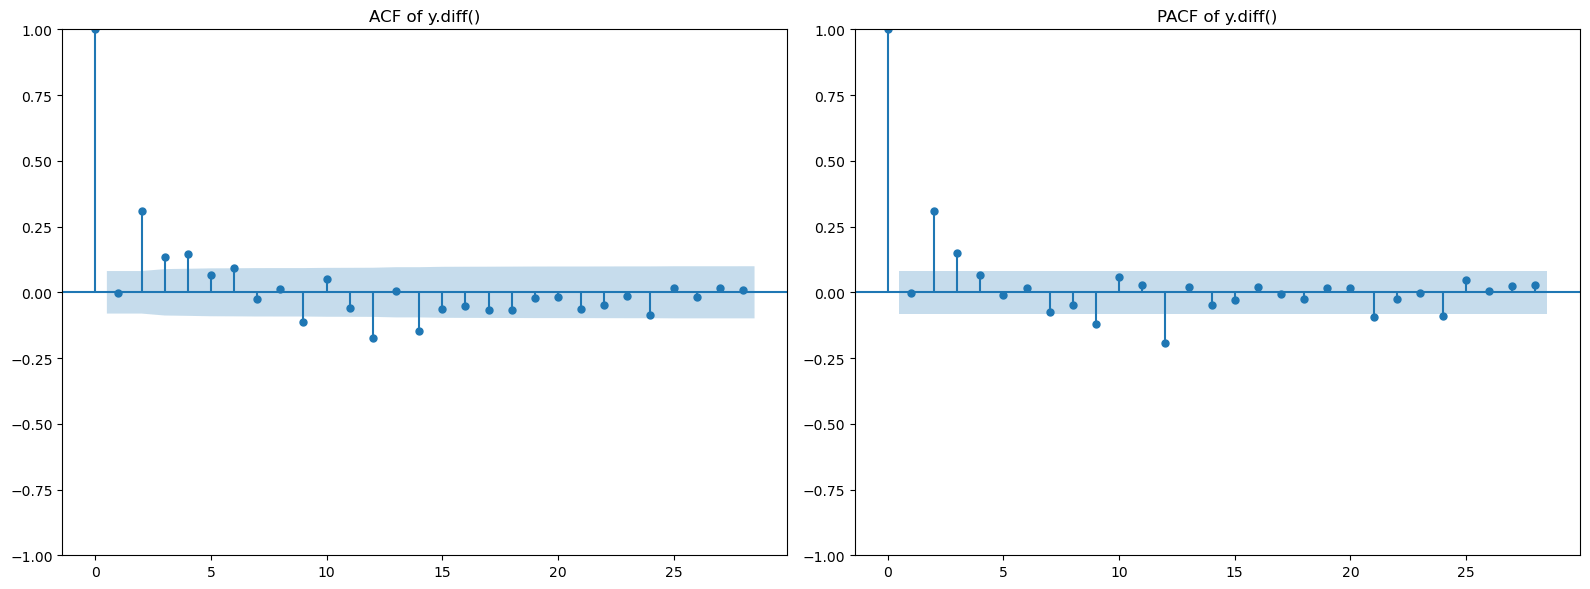

In [17]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plot_acf(y_train.diff().dropna(), ax=plt.gca())
plt.title('ACF of y.diff()')

plt.subplot(1, 2, 2)
plot_pacf(y_train.diff().dropna(), ax=plt.gca())
plt.title('PACF of y.diff()')

plt.tight_layout()

- Based on the ACF, we see that q = 2,3,4,9,12,14 are possible values for the MA component.
- Based on the PACF, we see that p = 2,3,9, 12 are possible values for the AR component.

### Fitting ARIMA

### ARIMA(2,1,2)

In [18]:
arima_model = pm.arima.ARIMA(order = (2,1,2))
arima_model.fit(y_train)

C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)


ARIMA(order=(2, 1, 2))

In [19]:
# Generate len(y_test) number of predictions 
y_pred = arima_model.predict(n_periods = len(y_test)) 
# we want as many future predictions as there are in y_test
mape = mean_absolute_percentage_error(y_test, y_pred)
print(mape)

0.3362130591878573


### ARIMA(2,1,3)

In [20]:
arima_model = pm.arima.ARIMA(order = (2,1,3))
arima_model.fit(y_train)

C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)


ARIMA(order=(2, 1, 3))

In [21]:
# Generate len(y_test) number of predictions 
y_pred = arima_model.predict(n_periods = len(y_test)) 
# we want as many future predictions as there are in y_test
mape = mean_absolute_percentage_error(y_test, y_pred)
print(mape)

0.3279760464521308


### ARIMA(2,1,4)

In [22]:
arima_model = pm.arima.ARIMA(order = (2,1,4))
arima_model.fit(y_train)

C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)


ARIMA(order=(2, 1, 4))

In [23]:
# Generate len(y_test) number of predictions 
y_pred = arima_model.predict(n_periods = len(y_test)) 
# we want as many future predictions as there are in y_test
mape = mean_absolute_percentage_error(y_test, y_pred)
print(mape)

0.32576029952689184


### ARIMA(3,1,2)

In [24]:
arima_model = pm.arima.ARIMA(order = (3,1,2))
arima_model.fit(y_train)

C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(order=(3, 1, 2))

In [25]:
# Generate len(y_test) number of predictions 
y_pred = arima_model.predict(n_periods = len(y_test)) 
# we want as many future predictions as there are in y_test
mape = mean_absolute_percentage_error(y_test, y_pred)
print(mape)

0.3512049028099577


### ARIMA(3,1,3)

In [26]:
arima_model = pm.arima.ARIMA(order = (3,1,3))
arima_model.fit(y_train)

C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\charm\mambaforge\envs\dsi-sg\lib\sit

ARIMA(order=(3, 1, 3))

In [27]:
# Generate len(y_test) number of predictions 
y_pred = arima_model.predict(n_periods = len(y_test)) 
# we want as many future predictions as there are in y_test
mape = mean_absolute_percentage_error(y_test, y_pred)
print(mape)

0.20433699681003728


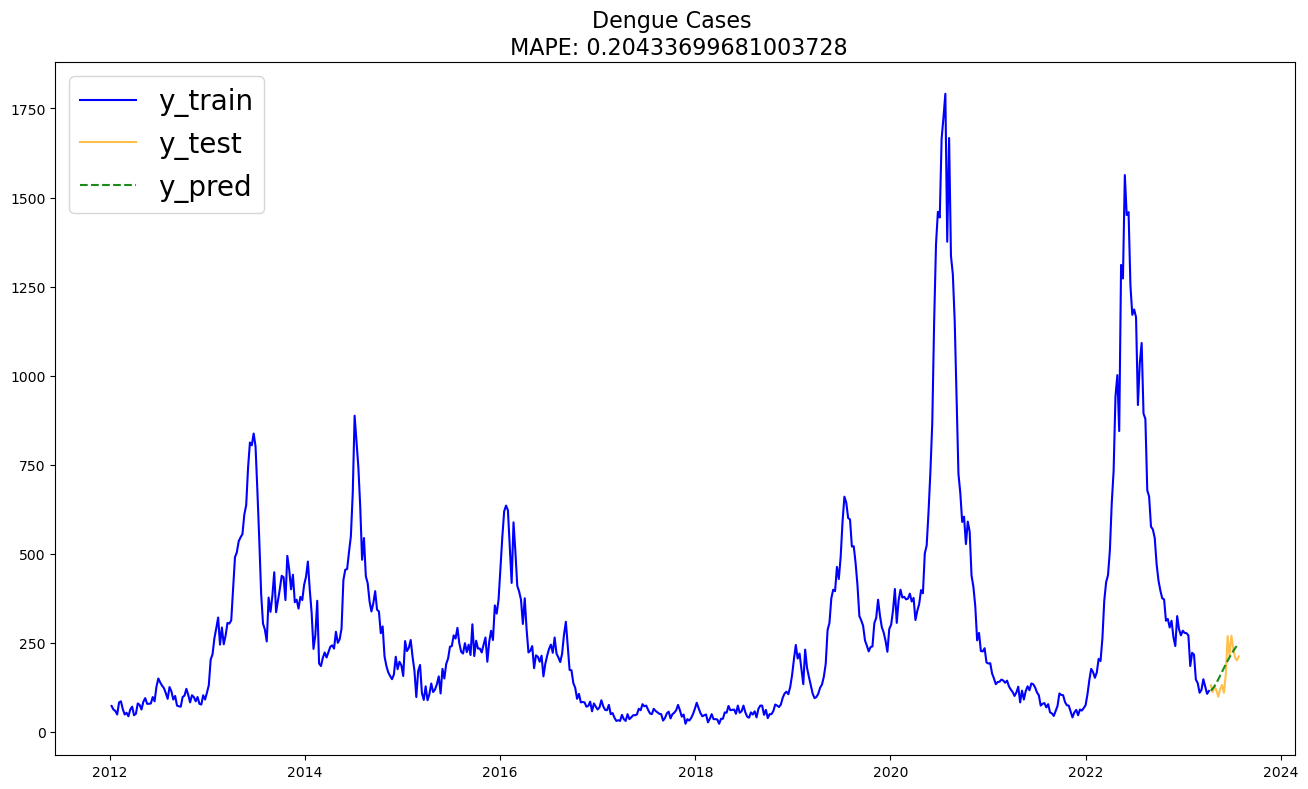

In [28]:
plot_forecast(y_train, y_test, arima_model)

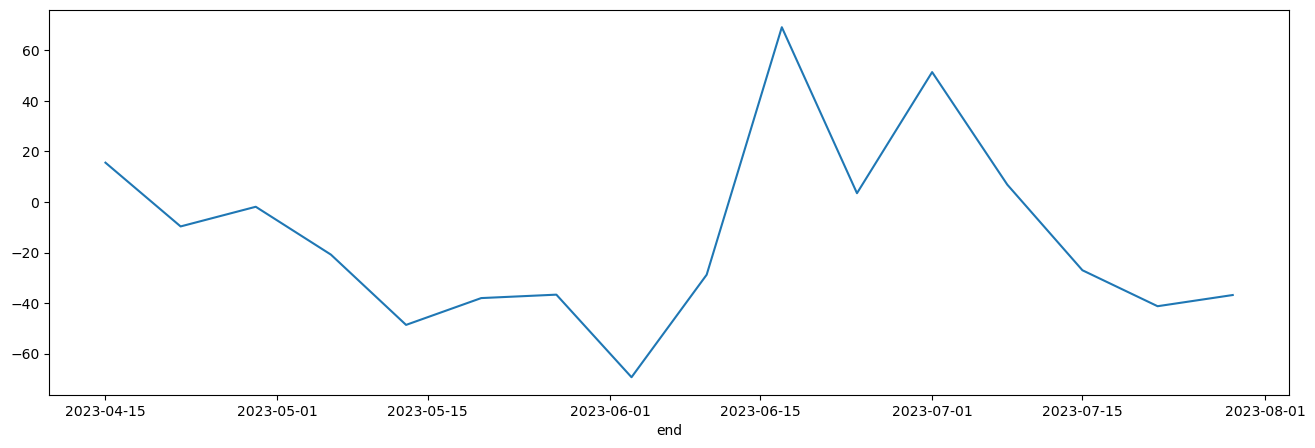

In [29]:
resid = y_test - y_pred
plt.figure(figsize=(16,5))
sns.lineplot(resid);

### ARIMA(3,1,4)

We see that the plot of the residuals deviates significantly from that of a white noise pattern (mean is not 0). This indicates that the ARIMA model might is not effective at capturing all the changes in the time series.

In [30]:
arima_model = pm.arima.ARIMA(order = (3,1,4))
arima_model.fit(y_train)

C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\charm\mambaforge\envs\dsi-sg\lib\sit

ARIMA(order=(3, 1, 4))

In [31]:
# Generate len(y_test) number of predictions 
y_pred = arima_model.predict(n_periods = len(y_test)) 
# we want as many future predictions as there are in y_test
mape = mean_absolute_percentage_error(y_test, y_pred)
print(mape)

0.3600480297713637


## SARIMA

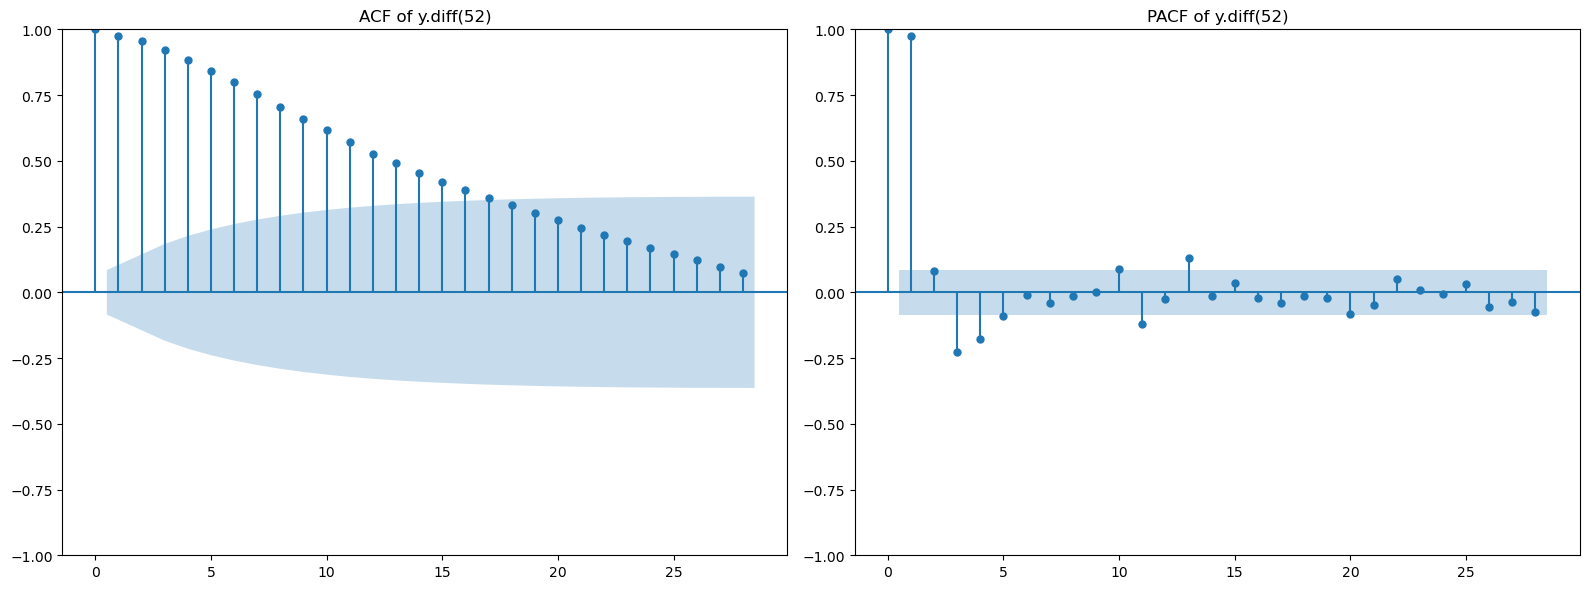

In [32]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plot_acf(y_train.diff(52).dropna(), ax=plt.gca())
plt.title('ACF of y.diff(52)')

plt.subplot(1, 2, 2)
plot_pacf(y_train.diff(52).dropna(), ax=plt.gca())
plt.title('PACF of y.diff(52)')

plt.tight_layout()

- Based on the PACF, we see that P = 1,3,4 are possible values for the SAR component.

### P = 1

C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)


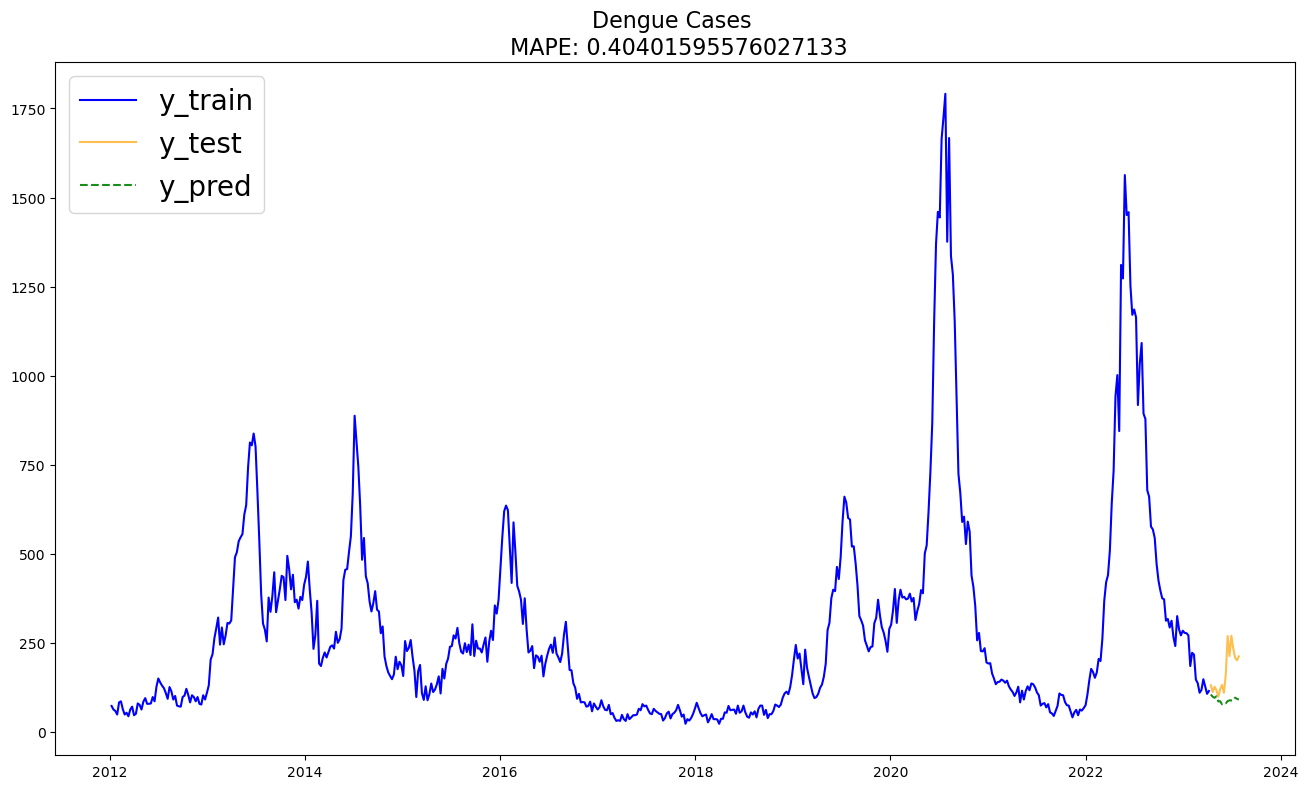

In [33]:
sarima_model = pm.arima.ARIMA(order = (2,1,2), seasonal_order = (1,0,0,52))
sarima_model.fit(y_train)
plot_forecast(y_train, y_test, sarima_model)

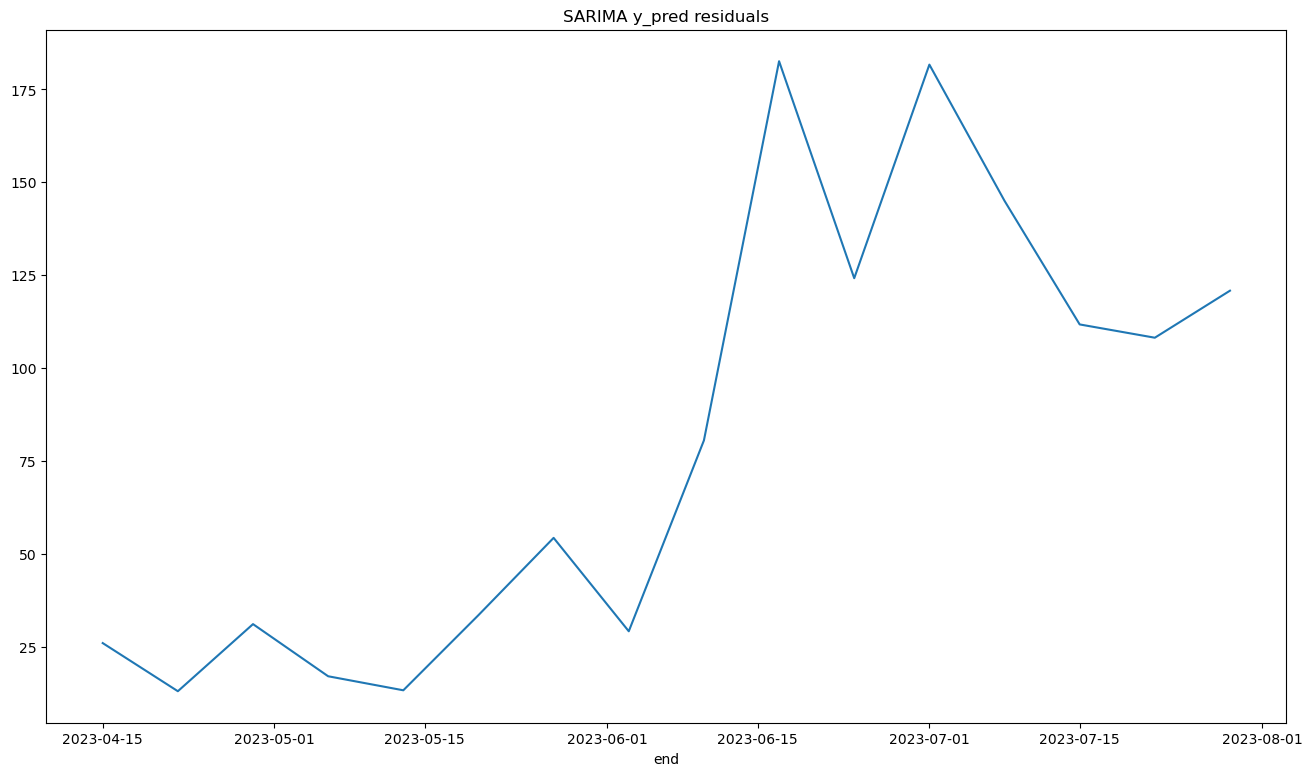

In [34]:
y_pred = sarima_model.predict(n_periods = len(y_test)) # we want as many future predictions as there are in y_test
mape = mean_absolute_percentage_error(y_test, y_pred)
resid = y_test - y_pred
plt.figure(figsize=(16,9))
plt.title('SARIMA y_pred residuals')
sns.lineplot(resid);

### P = 3

In [35]:
sarima_model = pm.arima.ARIMA(order = (2,1,2), seasonal_order = (3,0,0,52))
sarima_model.fit(y_train)

C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)


ARIMA(order=(2, 1, 2), seasonal_order=(3, 0, 0, 52))

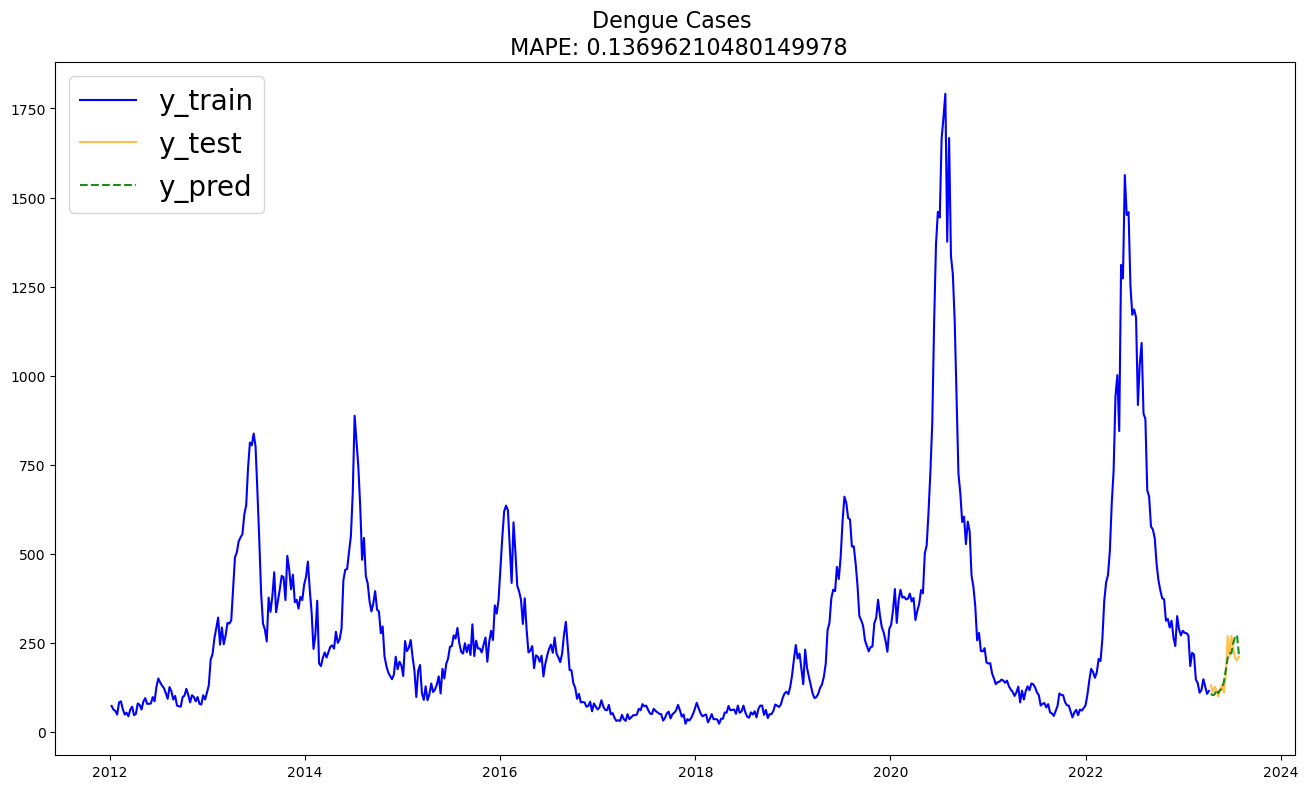

In [36]:
plot_forecast(y_train, y_test, sarima_model)

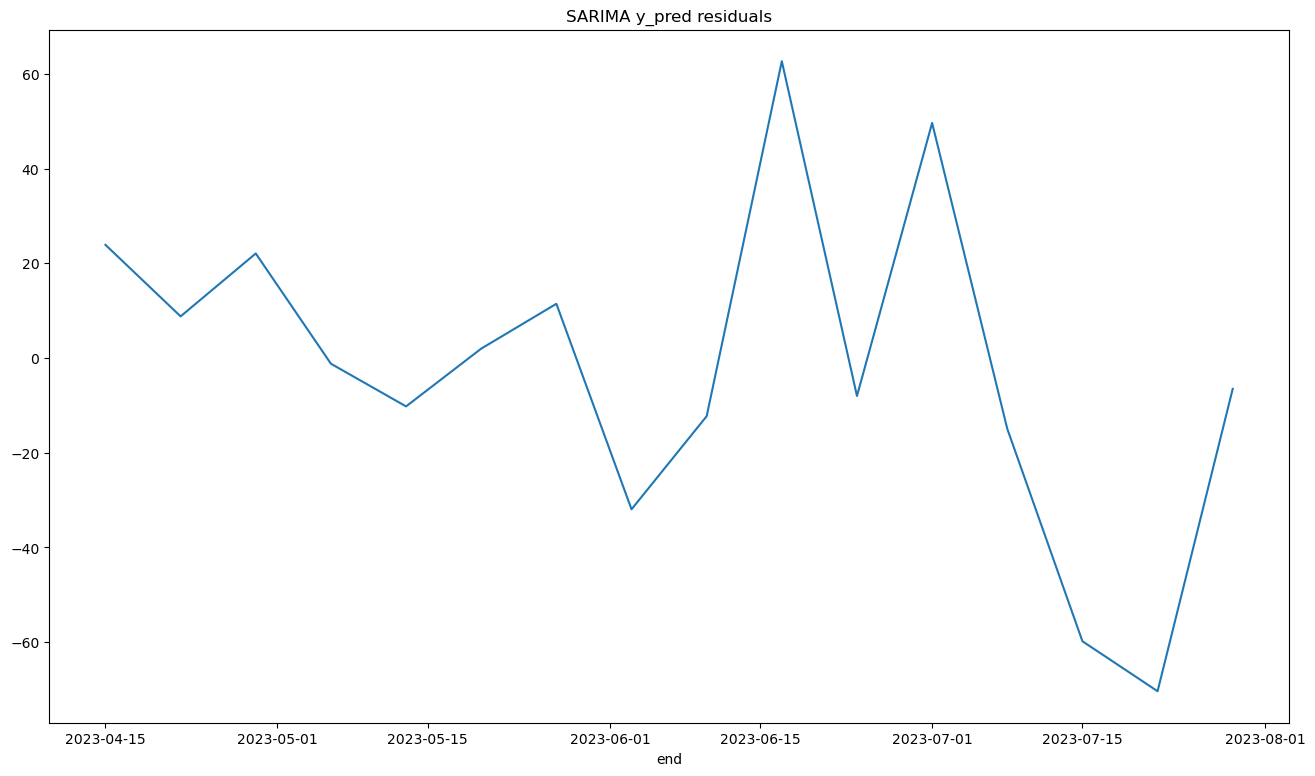

In [37]:
# Generate len(y_test) number of predictions 
y_pred = sarima_model.predict(n_periods = len(y_test)) # we want as many future predictions as there are in y_test
mape = mean_absolute_percentage_error(y_test, y_pred)
resid = y_test - y_pred
plt.figure(figsize=(16,9))
plt.title('SARIMA y_pred residuals')
sns.lineplot(resid);

White the reiduals of the SARIMA model has a mean value closer to 0, it doesn not appear to be of constant variance. The variance up till 2023-06-01 looks to be smaller than the variance after.

This indicates that the SARIMA model might is also not effective at capturing all the changes in the time series.

### P = 4

In [38]:
sarima_model = pm.arima.ARIMA(order = (2,1,2), seasonal_order = (4,0,0,52))
sarima_model.fit(y_train)

C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)


ARIMA(order=(2, 1, 2), seasonal_order=(4, 0, 0, 52))

In [39]:
# Generate len(y_test) number of predictions 
y_pred = sarima_model.predict(n_periods = len(y_test)) # we want as many future predictions as there are in y_test
mape = mean_absolute_percentage_error(y_test, y_pred)
print(mape)

0.18420431678131552


## SARIMAX

### Compiling Exogeneous Factors

__Weather Data__

For weather data, we decide to try the 2-lagged weather data and the 10-lagged weather data.

Rationale behind 2-lagged: It takes mosquitos 2 weeks to grow from egg into adult mosquito

Rationale behind 10-lagged: The autocorrelation between each weather variable and dengue cases is at their highest when the lag is around 10.

2-lagged weather data:
weekly_rainfall_all

In [40]:
gt_2012_2023 = pd.read_csv('../data/google_trends_year_2012_2023.csv')
term_gt_2012_2023 = pd.read_csv('../data/term_google_trend_2012_2023.csv')

In [41]:
gt_2012_2023

,Unnamed: 0,Dengue fever: (Singapore),Insect repellent: (Singapore),end
0,0,39,0,2012-01-08
1,1,0,0,2012-01-15
2,2,0,0,2012-01-22
3,3,0,0,2012-01-29
4,4,0,79,2012-02-05
...,...,...,...,...
600,600,0,0,2023-07-09
601,601,17,0,2023-07-16
602,602,0,100,2023-07-23
603,603,0,0,2023-07-30


In [42]:
term_gt_2012_2023

,end,dengue fever: (Singapore),insect repellent: (Singapore),end.1
0,2012-01-08,8,4,2012-01-08
1,2012-01-15,10,0,2012-01-15
2,2012-01-22,11,2,2012-01-22
3,2012-01-29,8,0,2012-01-29
4,2012-02-05,9,0,2012-02-05
...,...,...,...,...
602,2023-07-23,24,17,2023-07-23
603,2023-07-30,28,5,2023-07-30
604,2023-08-06,27,10,2023-08-06
605,2023-08-13,22,13,2023-08-13


Extracting the relevant columns and setting index to be datetime index.

In [43]:
gt_2012_2023.index = gt_2012_2023['end']
gt_2012_2023.index.name = 'date'
gt_2012_2023 = gt_2012_2023[['Dengue fever: (Singapore)','Insect repellent: (Singapore)']]
gt_2012_2023

,Dengue fever: (Singapore),Insect repellent: (Singapore)
date,,
2012-01-08,39,0
2012-01-15,0,0
2012-01-22,0,0
2012-01-29,0,0
2012-02-05,0,79
...,...,...
2023-07-09,0,0
2023-07-16,17,0
2023-07-23,0,100


Extracting the relevant columns and setting index to be datetime index.

In [44]:
term_gt_2012_2023.index = term_gt_2012_2023['end']
term_gt_2012_2023.index.name = 'date'
term_gt_2012_2023 = term_gt_2012_2023[['dengue fever: (Singapore)','insect repellent: (Singapore)']]
term_gt_2012_2023

,dengue fever: (Singapore),insect repellent: (Singapore)
date,,
2012-01-08,8,4
2012-01-15,10,0
2012-01-22,11,2
2012-01-29,8,0
2012-02-05,9,0
...,...,...
2023-07-23,24,17
2023-07-30,28,5
2023-08-06,27,10


In [45]:
weekly_rainfall_all = pd.read_csv('../data/weekly_weather_sg.csv')

Changing the index into datetime index, dropping 'station' column because it provides no value

In [46]:
weekly_rainfall_all['date'] = pd.to_datetime(weekly_rainfall_all['date'])
weekly_rainfall_all.drop('station', axis = 1, inplace = True)
weekly_rainfall_all.index = weekly_rainfall_all['date']
weekly_rainfall_all

,date,weekly mean rainfall (mm),highest 30 min rainfall(mm),highest 60 min rainfall (mm),highest 120 min rainfall (mm),mean temperature,maximum temperature,minimum temperature
date,,,,,,,,
2012-01-01,2012-01-01,0.342857,6.55,6.55,6.55,27.314286,31.4,24.5
2012-01-08,2012-01-08,7.428571,6.55,6.55,6.55,25.914286,30.9,23.8
2012-01-15,2012-01-15,3.485714,6.55,6.55,6.55,26.971429,32.5,22.1
2012-01-22,2012-01-22,1.371429,6.55,6.55,6.55,26.557143,31.6,23.5
2012-01-29,2012-01-29,8.328571,6.55,6.55,6.55,26.414286,31.6,21.5
...,...,...,...,...,...,...,...,...
2023-07-02,2023-07-02,2.257143,11.20,14.20,14.20,28.785714,33.6,23.9
2023-07-09,2023-07-09,9.428571,16.60,24.60,27.00,27.942857,32.9,22.9
2023-07-16,2023-07-16,10.800000,31.60,37.80,42.20,28.500000,32.5,22.8


Lagging the rainfall data by 2 weeks and applying MinMaxScalar

In [47]:
lag_2_weekly_rainfall_all = weekly_rainfall_all.drop('date',axis = 1).shift(2)
lag_2_weekly_rainfall_all = pd.DataFrame(ss.fit_transform(lag_2_weekly_rainfall_all), columns = lag_2_weekly_rainfall_all.columns, index = lag_2_weekly_rainfall_all.index)
print(lag_2_weekly_rainfall_all.shape)
lag_2_weekly_rainfall_all.head()

(614, 7)


,weekly mean rainfall (mm),highest 30 min rainfall(mm),highest 60 min rainfall (mm),highest 120 min rainfall (mm),mean temperature,maximum temperature,minimum temperature
date,,,,,,,
2012-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-15,0.001988,0.103312,0.08027,0.076519,0.561644,0.587629,0.507042
2012-01-22,0.043064,0.103312,0.08027,0.076519,0.337900,0.536082,0.408451
2012-01-29,0.020207,0.103312,0.08027,0.076519,0.506849,0.701031,0.169014


In [48]:
lag_2_weekly_rainfall_all = lag_2_weekly_rainfall_all[~lag_2_weekly_rainfall_all.index.duplicated(keep='first')]

In [49]:
lag_2_weekly_rainfall_all

,weekly mean rainfall (mm),highest 30 min rainfall(mm),highest 60 min rainfall (mm),highest 120 min rainfall (mm),mean temperature,maximum temperature,minimum temperature
date,,,,,,,
2012-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-15,0.001988,0.103312,0.080270,0.076519,0.561644,0.587629,0.507042
2012-01-22,0.043064,0.103312,0.080270,0.076519,0.337900,0.536082,0.408451
2012-01-29,0.020207,0.103312,0.080270,0.076519,0.506849,0.701031,0.169014
...,...,...,...,...,...,...,...
2023-07-02,0.009772,0.050473,0.068627,0.091121,0.872146,0.783505,0.380282
2023-07-09,0.079172,0.526814,0.443627,0.453271,0.767123,0.731959,0.366197
2023-07-16,0.013085,0.176656,0.174020,0.165888,0.796804,0.814433,0.422535


##### __Google Trends__

In [50]:
gt_2012_2023

,Dengue fever: (Singapore),Insect repellent: (Singapore)
date,,
2012-01-08,39,0
2012-01-15,0,0
2012-01-22,0,0
2012-01-29,0,0
2012-02-05,0,79
...,...,...
2023-07-09,0,0
2023-07-16,17,0
2023-07-23,0,100


In [51]:
dengue_gt_scaled= pd.DataFrame(gt_2012_2023[['Dengue fever: (Singapore)','Insect repellent: (Singapore)']][:605])
dengue_gt_scaled = pd.DataFrame(ss.fit_transform(dengue_gt_scaled), columns = dengue_gt_scaled.columns, index = gt_2012_2023[:605].index)
dengue_gt_scaled.index.name = 'date'
dengue_gt_scaled.index = pd.to_datetime(dengue_gt_scaled.index)
print(dengue_gt_scaled.head(1))
print(dengue_gt_scaled.tail(1))

            Dengue fever: (Singapore)  Insect repellent: (Singapore)
date                                                                
2012-01-08                       0.39                            0.0
            Dengue fever: (Singapore)  Insect repellent: (Singapore)
date                                                                
2023-08-06                        0.0                            0.0


##### __Other Diseases__

In [52]:
dengue_related_diseases = wid_2012_2023_ades_vector[['dengue haemorrhagic fever', 'chikungunya fever','zika virus infection']]
dengue_related_diseases = pd.DataFrame(ss.fit_transform(dengue_related_diseases), columns = dengue_related_diseases.columns, index = dengue_related_diseases.index)
dengue_related_diseases.index.name = 'date'
dengue_related_diseases.index = dengue_related_diseases.index + pd.DateOffset(1)
dengue_related_diseases.head()

,dengue haemorrhagic fever,chikungunya fever,zika virus infection
date,,,
2012-01-08,0.000,0.000000,0.0
2012-01-15,0.250,0.020408,0.0
2012-01-22,0.125,0.020408,0.0
2012-01-29,0.250,0.000000,0.0
2012-02-05,0.125,0.000000,0.0


In [53]:
for i in dengue_gt_scaled.index:
    if i not in lag_2_weekly_rainfall_all[~lag_2_weekly_rainfall_all.index.duplicated(keep='first')].index:
        print(i)        

2023-08-06 00:00:00


## Creating X of SARIMA-X

In [54]:
dengue_gt_scaled.index

DatetimeIndex(['2012-01-08', '2012-01-15', '2012-01-22', '2012-01-29',
               '2012-02-05', '2012-02-12', '2012-02-19', '2012-02-26',
               '2012-03-04', '2012-03-11',
               ...
               '2023-06-04', '2023-06-11', '2023-06-18', '2023-06-25',
               '2023-07-02', '2023-07-09', '2023-07-16', '2023-07-23',
               '2023-07-30', '2023-08-06'],
              dtype='datetime64[ns]', name='date', length=605, freq=None)

In [55]:
X = pd.merge(dengue_related_diseases, dengue_gt_scaled, on = 'date')

In [56]:
dengue_gt_scaled

,Dengue fever: (Singapore),Insect repellent: (Singapore)
date,,
2012-01-08,0.39,0.00
2012-01-15,0.00,0.00
2012-01-22,0.00,0.00
2012-01-29,0.00,0.00
2012-02-05,0.00,0.79
...,...,...
2023-07-09,0.00,0.00
2023-07-16,0.17,0.00
2023-07-23,0.00,1.00


In [57]:
dengue_related_diseases

,dengue haemorrhagic fever,chikungunya fever,zika virus infection
date,,,
2012-01-08,0.000,0.000000,0.000000
2012-01-15,0.250,0.020408,0.000000
2012-01-22,0.125,0.020408,0.000000
2012-01-29,0.250,0.000000,0.000000
2012-02-05,0.125,0.000000,0.000000
...,...,...,...
2023-07-02,0.000,0.000000,0.004651
2023-07-09,0.000,0.000000,0.000000
2023-07-16,0.000,0.000000,0.000000


Checking structure/format of X

In [58]:
X

,dengue haemorrhagic fever,chikungunya fever,zika virus infection,Dengue fever: (Singapore),Insect repellent: (Singapore)
date,,,,,
2012-01-08,0.000,0.000000,0.000000,0.39,0.00
2012-01-15,0.250,0.020408,0.000000,0.00,0.00
2012-01-22,0.125,0.020408,0.000000,0.00,0.00
2012-01-29,0.250,0.000000,0.000000,0.00,0.00
2012-02-05,0.125,0.000000,0.000000,0.00,0.79
...,...,...,...,...,...
2023-07-02,0.000,0.000000,0.004651,0.00,0.00
2023-07-09,0.000,0.000000,0.000000,0.00,0.00
2023-07-16,0.000,0.000000,0.000000,0.17,0.00


In [59]:
dengue_related_diseases

,dengue haemorrhagic fever,chikungunya fever,zika virus infection
date,,,
2012-01-08,0.000,0.000000,0.000000
2012-01-15,0.250,0.020408,0.000000
2012-01-22,0.125,0.020408,0.000000
2012-01-29,0.250,0.000000,0.000000
2012-02-05,0.125,0.000000,0.000000
...,...,...,...
2023-07-02,0.000,0.000000,0.004651
2023-07-09,0.000,0.000000,0.000000
2023-07-16,0.000,0.000000,0.000000


Since the weather dataframe, lag_2_weekly_rainfall_all, was lagged by two weeks, we will drop the first two weeks from X 

In [60]:
X = X[2:]

In [61]:
X

,dengue haemorrhagic fever,chikungunya fever,zika virus infection,Dengue fever: (Singapore),Insect repellent: (Singapore)
date,,,,,
2012-01-22,0.125,0.020408,0.000000,0.00,0.00
2012-01-29,0.250,0.000000,0.000000,0.00,0.00
2012-02-05,0.125,0.000000,0.000000,0.00,0.79
2012-02-12,0.000,0.000000,0.000000,0.33,0.00
2012-02-19,0.000,0.000000,0.000000,0.00,0.00
...,...,...,...,...,...
2023-07-02,0.000,0.000000,0.004651,0.00,0.00
2023-07-09,0.000,0.000000,0.000000,0.00,0.00
2023-07-16,0.000,0.000000,0.000000,0.17,0.00


In [62]:
dengue_gt_scaled

,Dengue fever: (Singapore),Insect repellent: (Singapore)
date,,
2012-01-08,0.39,0.00
2012-01-15,0.00,0.00
2012-01-22,0.00,0.00
2012-01-29,0.00,0.00
2012-02-05,0.00,0.79
...,...,...
2023-07-09,0.00,0.00
2023-07-16,0.17,0.00
2023-07-23,0.00,1.00


In [63]:
X =pd.merge(X, lag_2_weekly_rainfall_all, on = 'date')

Make y the same as X (dates, number of entries)

In [64]:
y.index = y.index + pd.DateOffset(1)
#removing the first two rows of y since we're missing 2 weeks from X
y = y[2:]

In [65]:
X

,dengue haemorrhagic fever,chikungunya fever,zika virus infection,Dengue fever: (Singapore),Insect repellent: (Singapore),weekly mean rainfall (mm),highest 30 min rainfall(mm),highest 60 min rainfall (mm),highest 120 min rainfall (mm),mean temperature,maximum temperature,minimum temperature
date,,,,,,,,,,,,
2012-01-22,0.125,0.020408,0.000000,0.00,0.00,0.043064,0.103312,0.080270,0.076519,0.337900,0.536082,0.408451
2012-01-29,0.250,0.000000,0.000000,0.00,0.00,0.020207,0.103312,0.080270,0.076519,0.506849,0.701031,0.169014
2012-02-05,0.125,0.000000,0.000000,0.00,0.79,0.007950,0.103312,0.080270,0.076519,0.440639,0.608247,0.366197
2012-02-12,0.000,0.000000,0.000000,0.33,0.00,0.048282,0.103312,0.080270,0.076519,0.417808,0.608247,0.084507
2012-02-19,0.000,0.000000,0.000000,0.00,0.00,0.000000,0.151420,0.117647,0.112150,0.577626,0.680412,0.492958
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-02,0.000,0.000000,0.004651,0.00,0.00,0.009772,0.050473,0.068627,0.091121,0.872146,0.783505,0.380282
2023-07-09,0.000,0.000000,0.000000,0.00,0.00,0.079172,0.526814,0.443627,0.453271,0.767123,0.731959,0.366197
2023-07-16,0.000,0.000000,0.000000,0.17,0.00,0.013085,0.176656,0.174020,0.165888,0.796804,0.814433,0.422535


In [67]:
X.reset_index().to_csv("../models/X.csv", index = False)

In [68]:
y.reset_index().to_csv("../models/y.csv", index = False)

## Train Test Split

In [69]:
y_train = y[:len(y)-(4*4)]
y_test = y[len(y_train):]
X_train = X[:len(X)-(4*4)]
X_test = X[len(X_train):]

In [ ]:
#joblib.dump(y_train, '../models/y_train.joblib')
#joblib.dump(y_test, '../models/y_test.joblib')
#joblib.dump(X_train, '../models/X_train.joblib')
#joblib.dump(X_test, '../models/X_test.joblib')

In [70]:
sarimax_model = pm.arima.ARIMA(order = (2,1,2), seasonal_order = (3,0,0,52))
sarimax_model.fit(y_train, X_train)

C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\charm\mambaforge\envs\dsi-sg\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(order=(2, 1, 2), seasonal_order=(3, 0, 0, 52))

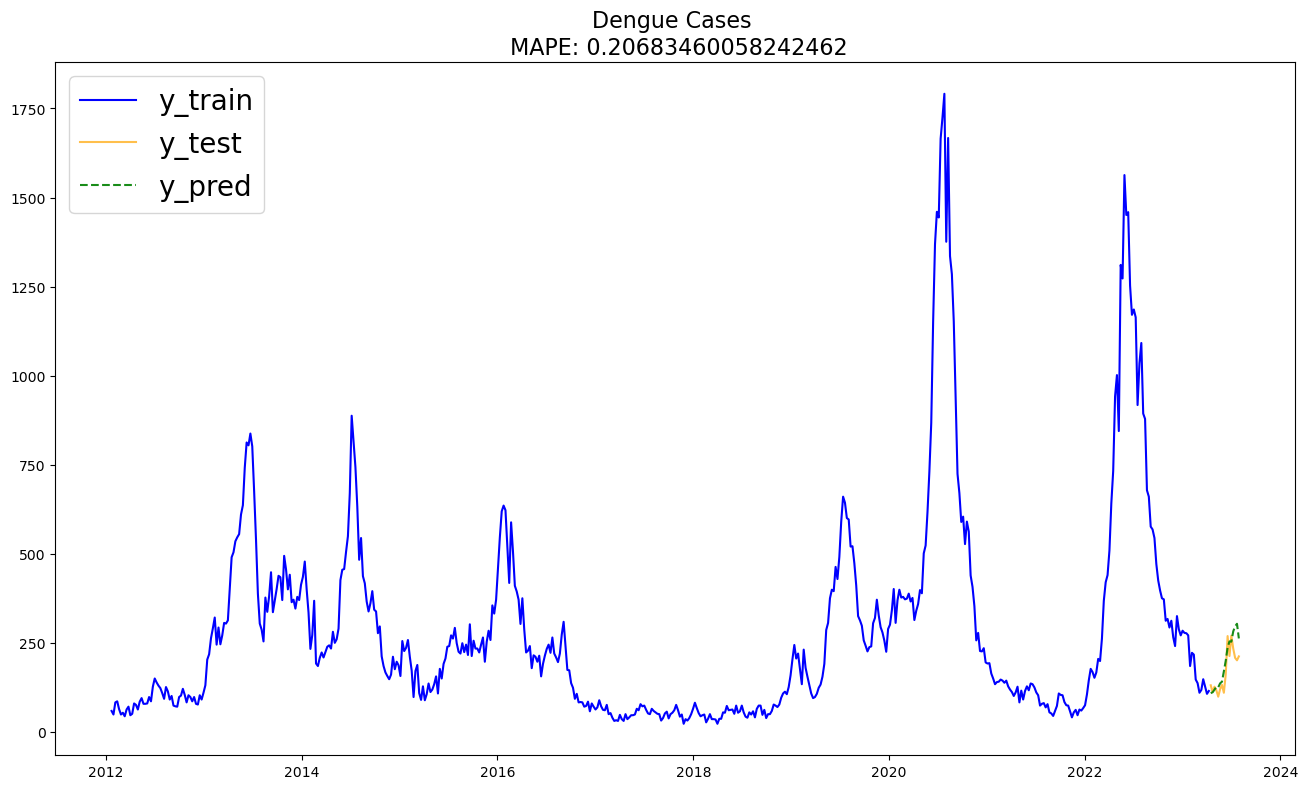

In [71]:
plot_forecast(y_train, y_test, sarimax_model, X_test = X_test)

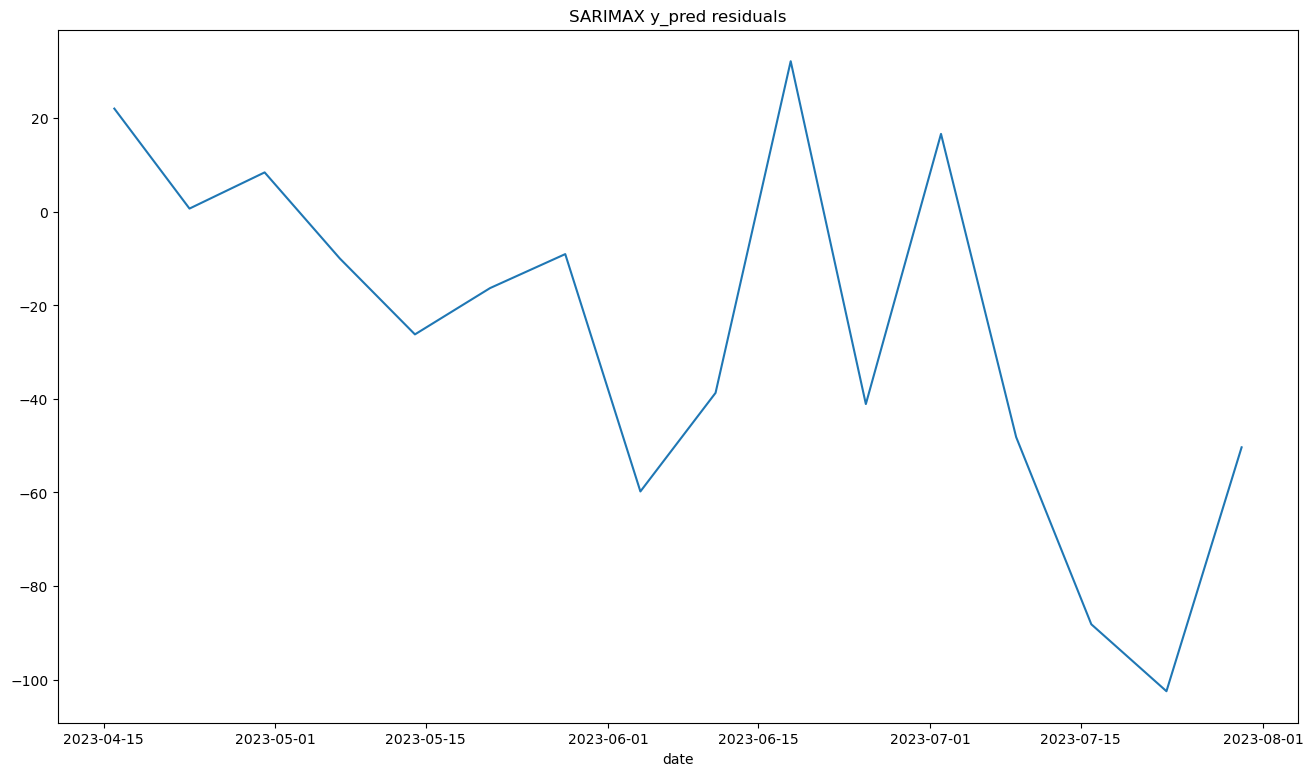

In [72]:
# Generate len(y_test) number of predictions 
y_pred = sarimax_model.predict(n_periods = len(y_test), X=X_test) # we want as many future predictions as there are in y_test
mape = mean_absolute_percentage_error(y_test, y_pred)
resid = y_test - y_pred
plt.figure(figsize=(16,9))
plt.title('SARIMAX y_pred residuals')
sns.lineplot(resid);

The residual plot for SARIMAX is worse than that of SARIMA, as is its MAPE.

In [73]:
sarimax_model_free = pm.AutoARIMA(start_p=0, max_p=10, 
                           d=1,    # find optimum value of d automatically
                           start_q=0, max_q=10,
                           start_P=0, max_P=10,
                           D=None,
                           start_Q=0, max_Q=10,
                           seasonal=True,
                           m= 52,
                           trace=True, # Print values for each fit in the grid search
                           random_state=20,
                           n_fits=1000
                          )
sarimax_model_free.fit(y_train, X_train)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=6529.769, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=6533.745, Time=2.38 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=6533.756, Time=3.12 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=6527.770, Time=0.46 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=6531.763, Time=2.16 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=6531.762, Time=3.64 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=6533.654, Time=12.08 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=6531.747, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=6531.760, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=6509.597, Time=1.49 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=6511.021, Time=17.88 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AIC=6510.757, Time=19.28 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=22.59 sec
 ARIMA(2,1,1)(0,0,0)[52] intercept   : AIC=6463.897, Time=1.75 sec
 ARIMA(2,1,1)(1,0,0)

AutoARIMA(d=1, m=52, max_P=10, max_Q=10, max_p=10, max_q=10, n_fits=1000,
          random_state=20, start_P=0, start_Q=0, start_p=0, start_q=0,
          trace=True)

In [74]:
y_pred = sarimax_model_free.predict(n_periods = len(y_test), X=X_test) # we want as many future predictions as there are in y_test
mape = mean_absolute_percentage_error(y_test, y_pred)
print(mape)

0.3178056551071604
